### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net2Loops.inp`. Let's start by setting up the model:

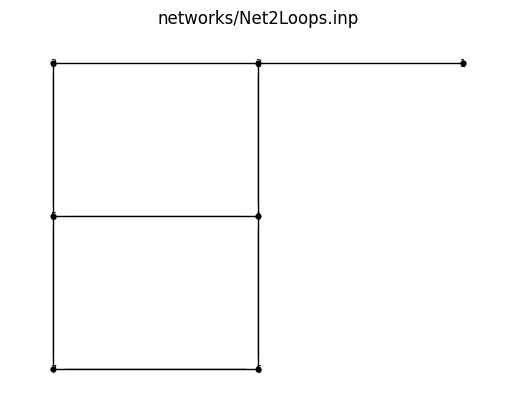

{'headloss': 'D-W',
 'hydraulics': None,
 'hydraulics_filename': None,
 'viscosity': 1.0,
 'specific_gravity': 1.0,
 'pattern': None,
 'demand_multiplier': 1.0,
 'demand_model': 'PDA',
 'minimum_pressure': 0.0,
 'required_pressure': 0.07,
 'pressure_exponent': 0.5,
 'emitter_exponent': 0.5,
 'trials': 40,
 'accuracy': 0.001,
 'unbalanced': 'CONTINUE',
 'unbalanced_value': 10,
 'checkfreq': 2,
 'maxcheck': 10,
 'damplimit': 0.0,
 'headerror': 0.0,
 'flowchange': 0.0,
 'inpfile_units': 'LPS',
 'inpfile_pressure_units': None}

In [1]:
import os
from pathlib import Path
import wntr
import wntr_quantum


epanet_tmp_dir = Path("/Users/murilo/scratch_dir/vqls_solver_net2loops")
if not epanet_tmp_dir.exists():
    epanet_tmp_dir.mkdir(parents=True, exist_ok=True)

os.environ["EPANET_TMP"] = str(epanet_tmp_dir)
os.environ["EPANET_QUANTUM"] = "/Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET"

# set up network model
inp_file = 'networks/Net2Loops.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# explicitly set Darcy-Weisbach head loss formulas and pressure dependent demand mode
wn.options.hydraulic.headloss = 'D-W'
wn.options.hydraulic.demand_model = 'PDD'

# print options
dict(wn.options.hydraulic)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [2]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

# load EPANET A and b matrices from temp
epanet_A, epanet_b = wntr_quantum.sim.epanet.load_epanet_matrix()

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = len(results_epanet.node["pressure"].iloc[0]), 
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

/Users/murilo/Library/CloudStorage/OneDrive-NetherlandseScienceCenter/Documents/NLeSC_Projects/Vitens/WNTR/wntr/epanet/io.py:1726: UserWarning: REQUIRED PRESSURE is below the lower limit for EPANET (0.1 in psi or m). The value has been set to 0.1 in the INP file.
  warnings.warn('REQUIRED PRESSURE is below the lower limit for EPANET (0.1 in psi or m). The value has been set to 0.1 in the INP file.')


Your EPANET quantum path: /Users/murilo/Documents/NLeSC_Projects/Vitens/EPANET
Your EPANET temp dir: /Users/murilo/scratch_dir/vqls_solver_net2loops

Size of the Jacobian in EPANET simulator: 6
Size of the b vector in EPANET simulator: 6


(name          2         3          4         5         6         7  \
 0     37.609756  0.019554  20.612926  0.003783  0.052195  0.003034   
 
 name             1  
 0     4.394531e-07  ,
 name        1        2        3        4         5         6         7  \
 0     0.16398  0.01634  0.11987  0.00651  0.080031  0.013801  0.004069   
 
 name         8  
 0    -0.004066  )

### Solve linear system with VQLS and the final matrices from EPANET

For testing purposes, we start by solving the linear system with VQLS and the final A and b matrices from the classical EPANET simulator. Here, we are **preconditioning** the initial linear system using diagonal scaling and also using a **mix of two classical optimizers**.

In [3]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="pauli",
    verbose=True,
    preconditioner="diagonal_scaling",
    reorder=True,
)

res = linear_solver(epanet_A, epanet_b)

100%|██████████| 64/64 [00:00<00:00, 1464.70it/s]


VQLS Iteration 633 Cost 6.495e-08
   Normal return from subroutine COBYLA

   NFVALS =  633   F = 6.494543E-08    MAXCV = 0.000000E+00
   X =-3.233546E+00   1.526569E+00  -3.289321E+00  -1.502851E+00  -1.365800E+00


100%|██████████| 64/64 [00:00<00:00, 5556.98it/s]

      -1.938064E+00   1.315281E+00   2.191449E-01  -1.626498E+00  -1.651050E+00
      -1.831240E+00   3.179654E+00


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 8
         Function evaluations: 156
         Gradient evaluations: 12


Let's check the evolution of the cost function

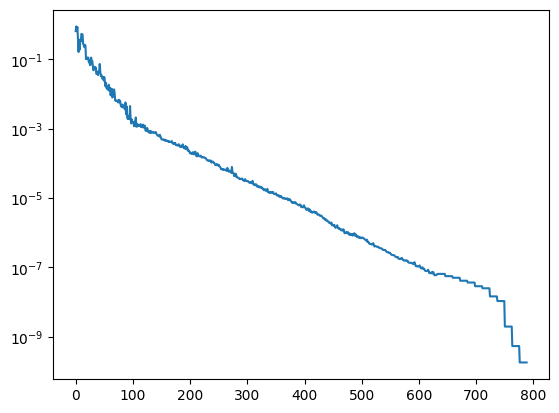

In [4]:
import matplotlib.pyplot as plt
plt.semilogy(res.logger.values)

and visualize graphically the solution

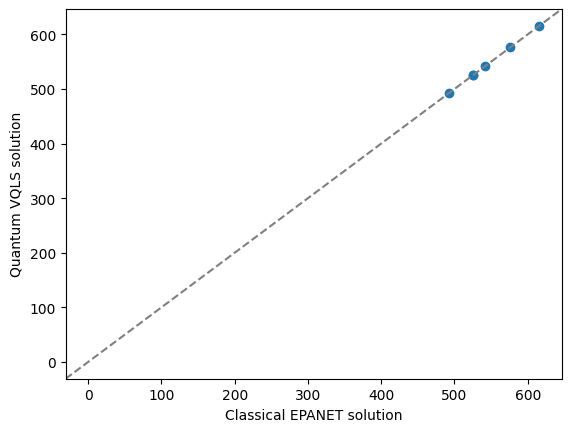

(array([524.944, 541.51 , 576.158, 615.518, 524.999, 492.138]),
 array([524.943, 541.509, 576.046, 615.507, 524.989, 492.14 ]))

In [5]:
import numpy as np 
ref = np.linalg.solve(epanet_A.todense(), epanet_b)

plt.scatter(ref, res.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.xlabel("Classical EPANET solution")
plt.ylabel("Quantum VQLS solution")
plt.show()

ref, res.solution